In [1]:
from pathlib import Path

import pandas as pd

from tqdm import tqdm
import pul_config
import importlib

importlib.reload(pul_config)

import utils

importlib.reload(utils)
from utils import (
    build_proba_df,
    build_ranked_lists,
    load_grid_searches,
    score_df_from_grid_searches,
    train,
)

# CHANGE HERE
input_dirs = [
    Path("1_outputs/standard/"),
    Path("1_outputs/small_DS/"),
    Path("1_outputs/large/"),
    Path("1_outputs/large_small_DS/"),
]
output_dirs = [
    Path("2_outputs/standard/"),
    Path("2_outputs/small_DS/"),
    Path("2_outputs/large/"),
    Path("2_outputs/large_small_DS/"),
]
method = "Elkanoto_XGBoost"
pul_cfg = pul_config.ElkanotoXGBoostConfig

remote_method = "Elkanoto_XGBoost"  # name of the output in S3
# -----

local_method = method
MODEL_NAMES = ("RotatE", "TransE", "CompGCN")
output_dirs = [output_dir / method for output_dir in output_dirs]

## Training

In [ ]:
N_JOBS = 40
CV = 5
rerun = True

for input_dir, output_dir in tqdm(zip(input_dirs, output_dirs), total=len(input_dirs)):
    train(
        input_dir=input_dir,
        output_dir=output_dir,
        model_names=MODEL_NAMES,
        cv=CV,
        n_jobs=N_JOBS,
        pul_cfg=pul_cfg,
        rerun=rerun,
    )

## Evaluation

In [4]:
grid_searches_list = [
    load_grid_searches(output_dir=o, model_names=MODEL_NAMES) for o in output_dirs
]

In [5]:
score_dfs = [
    score_df_from_grid_searches(gs, i) for gs, i in zip(grid_searches_list, input_dirs)
]
for output_dir, score_df in zip(output_dirs, score_dfs):
    score_df.to_csv(output_dir / "score_df.csv")

In [6]:
score_dfs[0].groupby("model_name").mean()

/tmp/ipykernel_56111/1470429527.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  score_dfs[0].groupby('model_name').mean()


,score10_val,score100_val,score10_test,score100_test,score10_all,score100_all,mr_all,mrr_all,amri_all,mr_test,mrr_test,amri_test,tp_test,fp_test,fn_test,tn_test,tp_all,fp_all,fn_all,tn_all
model_name,,,,,,,,,,,,,,,,,,,,
CompGCN,2.0,14.7,0.7,12.2,6.3,48.4,3382.954927,0.005986,0.646683,940.4536,0.006047,0.507495,2396.4,1294.6,37.5,87.5,12146.8,6379.2,118.3,500.7
RotatE,6.8,43.3,6.1,44.2,8.4,83.1,1371.558966,0.009277,0.856816,382.6808,0.024308,0.799905,3483.3,207.7,48.2,76.8,17613.7,912.3,154.6,464.4
TransE,3.9,30.7,4.6,33.1,7.3,65.7,2197.395961,0.007463,0.770539,520.8696,0.018650,0.727460,3279.3,411.7,45.2,79.8,16557.7,1968.3,169.2,449.8


Text(0, 0.5, 'score')

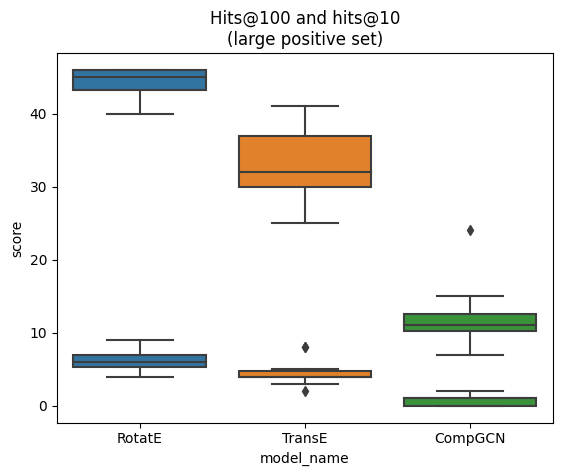

In [7]:
import seaborn as sns

sns.boxplot(score_dfs[0], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(large positive set)"
)
sns.boxplot(score_dfs[0], x="model_name", y="score100_test").set_ylabel("score")

Text(0, 0.5, 'score')

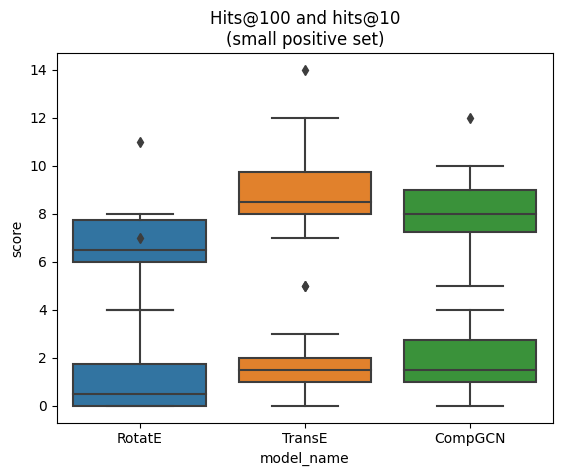

In [8]:
import seaborn as sns

sns.boxplot(score_dfs[1], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(small positive set)"
)
sns.boxplot(score_dfs[1], x="model_name", y="score100_test").set_ylabel("score")

Text(0, 0.5, 'score')

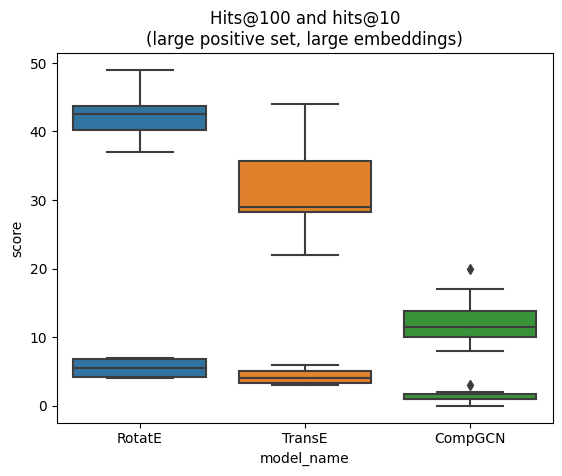

In [9]:
import seaborn as sns

sns.boxplot(score_dfs[2], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(large positive set, large embeddings)"
)
sns.boxplot(score_dfs[2], x="model_name", y="score100_test").set_ylabel("score")

Text(0, 0.5, 'score')

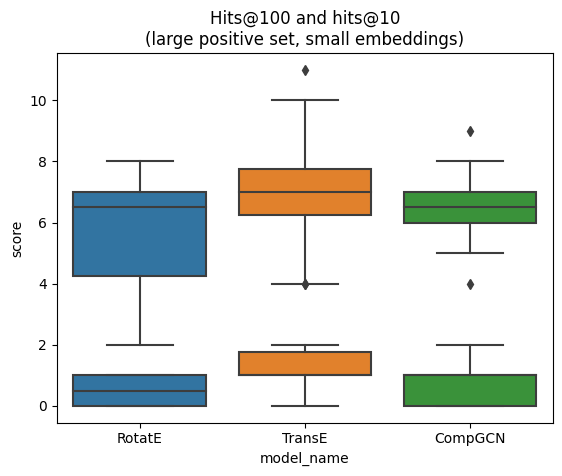

In [10]:
import seaborn as sns

sns.boxplot(score_dfs[3], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(large positive set, small embeddings)"
)
sns.boxplot(score_dfs[3], x="model_name", y="score100_test").set_ylabel("score")

In [11]:
score_dfs = []
for output_dir in output_dirs:
    score_dfs.append(pd.read_csv(output_dir / "score_df.csv", index_col=0))
plot_dfs = []
for ds, score_df in zip(
    ("large", "small", "large_embeddings", "large_embeddings_small"), score_dfs
):
    plot_df = score_df[["model_name", "score10_test", "score100_test"]].copy()
    plot_df.columns = ["model_name", "hits@10", "hits@100"]
    plot_df["dataset"] = ds
    plot_dfs.append(plot_df)

plot_df = pd.concat(plot_dfs)
plot_df = plot_df.melt(id_vars=["model_name", "dataset"])
plot_dfs = {k: v for k, v in plot_df.groupby("model_name")}

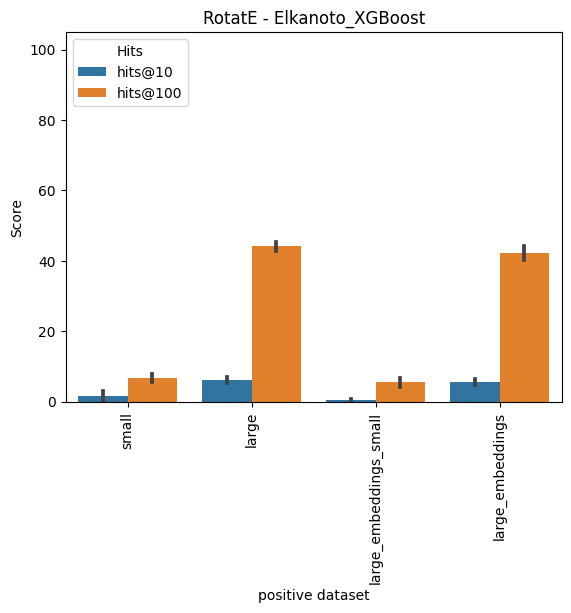

In [12]:
y_lim = (0, 105)
y_label = "Score"

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "RotatE"
plot_df = plot_dfs[model_name]

plot_df["Hits"] = plot_df["variable"]
plot = sns.barplot(
    plot_df,
    x="dataset",
    y="value",
    hue="Hits",
    order=["small", "large", "large_embeddings_small", "large_embeddings"],
)
sns.move_legend(plot, "upper left")
plot.set(xlabel="positive dataset", ylabel=y_label)
plot.set_title(f"{model_name} - {method}")
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(
    labels=["small", "large", "large_embeddings_small", "large_embeddings"], rotation=90
)

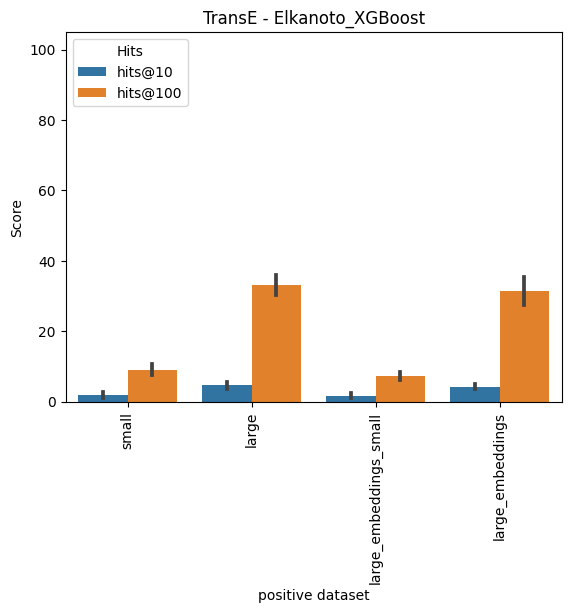

In [13]:
y_lim = (0, 105)
y_label = "Score"

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "TransE"
plot_df = plot_dfs[model_name]

plot_df["Hits"] = plot_df["variable"]
plot = sns.barplot(
    plot_df,
    x="dataset",
    y="value",
    hue="Hits",
    order=["small", "large", "large_embeddings_small", "large_embeddings"],
)
sns.move_legend(plot, "upper left")
plot.set(xlabel="positive dataset", ylabel=y_label)
plot.set_title(f"{model_name} - {method}")
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(
    labels=["small", "large", "large_embeddings_small", "large_embeddings"], rotation=90
)

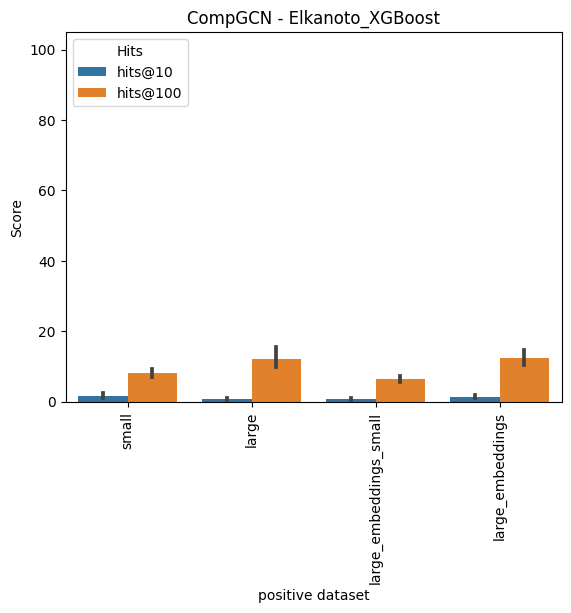

In [14]:
y_lim = (0, 105)
y_label = "Score"

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "CompGCN"
plot_df = plot_dfs[model_name]

plot_df["Hits"] = plot_df["variable"]
plot = sns.barplot(
    plot_df,
    x="dataset",
    y="value",
    hue="Hits",
    order=["small", "large", "large_embeddings_small", "large_embeddings"],
)
sns.move_legend(plot, "upper left")
plot.set(xlabel="positive dataset", ylabel=y_label)
plot.set_title(f"{model_name} - {method}")
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(
    labels=["small", "large", "large_embeddings_small", "large_embeddings"], rotation=90
)

In [15]:
proba_dfs = [
    build_proba_df(gs, i, mns=MODEL_NAMES)
    for gs, i in zip(grid_searches_list, input_dirs)
]
for output_dir, proba_df in zip(output_dirs, proba_dfs):
    proba_df.to_csv(output_dir / "proba_df.csv")

In [16]:
proba_df = proba_dfs[0]
proba_df.query("test").sort_values("RotatE_0", ascending=False)

,node_id,gene_name,irr,train,val,test,RotatE_0,RotatE_1,RotatE_2,RotatE_3,...,CompGCN_0,CompGCN_1,CompGCN_2,CompGCN_3,CompGCN_4,CompGCN_5,CompGCN_6,CompGCN_7,CompGCN_8,CompGCN_9
25808,Gene::5371,PML,False,False,False,True,4.070774,1.014546,1.100716,1.848076,...,1.201741,1.597497,2.573261,0.293595,1.615545,1.343499,1.519343,1.428539,1.078633,0.903912
32580,Gene::885,CCK,True,False,False,True,3.698868,0.804313,2.025947,2.292399,...,0.994026,0.555451,0.819861,0.666773,0.213870,0.182796,0.147720,5.386668,2.240223,0.592550
19107,Gene::2056,EPO,False,False,False,True,3.617982,3.123691,3.762550,3.103228,...,0.945955,0.474647,0.587495,0.839049,0.260215,0.261597,0.736922,0.984806,3.402589,1.141637
27045,Gene::5595,MAPK3,True,False,False,True,3.482064,3.171627,4.013504,2.112423,...,1.041178,1.331242,1.430058,0.891878,0.871931,1.533650,1.327818,0.812404,1.220829,0.576009
23098,Gene::3643,INSR,True,False,False,True,3.480241,3.489212,3.455289,1.815781,...,1.259960,1.597497,0.649745,0.987420,1.615545,1.341677,0.983178,0.636621,1.520176,1.365644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22583,Gene::338809,C12orf74,False,False,False,True,0.006849,0.122048,0.007416,0.007885,...,0.676249,0.133672,0.037331,0.022490,0.180986,0.103059,0.035548,0.027706,0.348979,0.254807
24328,Gene::440044,SLC22A20P,False,False,False,True,0.006849,0.122048,0.016339,0.013981,...,0.753757,1.358509,0.446304,0.264953,0.368016,0.226489,7.693820,1.503863,1.038773,0.052110
19322,Gene::220107,DLEU7,False,False,False,True,0.006849,0.122048,0.006746,0.007585,...,0.676249,0.133672,0.046717,0.028262,0.150352,0.158163,0.090933,0.093662,0.112991,0.060952
26429,Gene::55125,CEP192,False,False,False,True,0.006806,0.122048,0.006890,0.009588,...,0.676249,0.652971,0.127710,0.250179,0.145818,0.248817,0.452267,0.781810,0.579392,0.159882


In [17]:
for proba_df, score_df, od in zip(proba_dfs, score_dfs, output_dirs):
    proba_df.to_csv(od / "proba_df.csv")
    proba_df.query("test").to_csv(od / "proba_df_test.csv")
    score_df.to_csv(od / "score_df.csv")

    for mn in MODEL_NAMES:
        score_cols = [c for c in proba_df.columns if c.startswith(f"{mn}_")]
        tmp_df = proba_df[
            ["node_id", "gene_name", "irr", "train", "val", "test", *score_cols]
        ]
        tmp_df.to_csv(od / f"proba_df_{mn}.csv")
        tmp_df_test = tmp_df.query("test")
        tmp_df_test.to_csv(od / f"proba_df_test_{mn}.csv")

        genes_100 = build_ranked_lists(tmp_df, prefix=mn)
        genes_100.to_csv(od / f"genes_100_{mn}.csv", index=False)
        genes_100_test = build_ranked_lists(tmp_df_test, prefix=mn)
        genes_100_test.to_csv(od / f"genes_100_test_{mn}.csv", index=False)

        ds = "test"
        score_df_tmp = score_df.query("model_name == @mn")
        score_df_tmp = pd.concat(
            [score_df_tmp["m_name"], score_df_tmp.filter(regex=f".*_{ds}", axis=1)],
            axis=1,
        ).set_index("m_name")
        score_df_tmp.columns = [
            c.replace(f"_{ds}", "").replace("score", "hits@")
            for c in score_df_tmp.columns
        ]
        score_df_tmp = score_df_tmp.T
        score_df_tmp["mean"] = score_df_tmp.mean(axis=1)
        score_df_tmp.to_csv(od / f"scores_{ds}_{mn}.csv", index_label="score")

        ds = "all"
        score_df_tmp = score_df.query("model_name == @mn")
        score_df_tmp = pd.concat(
            [score_df_tmp["m_name"], score_df_tmp.filter(regex=f".*_{ds}", axis=1)],
            axis=1,
        ).set_index("m_name")
        score_df_tmp.columns = [
            c.replace(f"_{ds}", "").replace("score", "hits@")
            for c in score_df_tmp.columns
        ]
        score_df_tmp = score_df_tmp.T
        score_df_tmp["mean"] = score_df_tmp.mean(axis=1)
        score_df_tmp.to_csv(od / f"scores_{mn}.csv", index_label="score")